### Import libraries

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix , accuracy_score, classification_report
from sklearn.metrics import plot_confusion_matrix
from sklearn.ensemble import RandomForestClassifier

In [2]:
np.random.seed(42)

### Data Generating Process

In [3]:
# helper func
def return_proportions(quantity, total, lower_bound):    
    total -= quantity * lower_bound
    cumulative_sum = [0, total] + list(np.random.randint(0, total, quantity-1))
    cumulative_sum.sort()
    vals = [cumulative_sum[i] - cumulative_sum[i-1] + lower_bound
            for i in range(1, len(cumulative_sum))]
    return vals 

In [4]:
def gen_samples(global_mean, global_std, n_classes, n_samples=10_000, lower_bound=100, name_of_feature='x1'):
    
    classwise_means = np.random.normal(global_mean, global_std, n_classes)
    
    classwise_std = np.abs(
        np.random.randint(0, global_std*2, n_classes) 
        + np.random.randn(n_classes)
    )
    
    proportions = return_proportions(n_classes, n_samples, lower_bound)
    
    print(f'For {name_of_feature}:\n---\nMeans: {np.round(classwise_means, 2)}')
    print(f'StdDev: {np.round(classwise_std, 2)}')
    print(f'Proportion: {proportions}\n---\n---')
    
    samples = np.concatenate(
        [np.random.normal(classwise_means[i], 
                          classwise_std[i],
                          proportions[i])
         for i in range(n_classes)
        ]
    )
    
    class_labels = np.concatenate([np.full(prop, index)
                   for index, prop in enumerate(proportions)
                   ])
    
    df = pd.DataFrame({name_of_feature:samples, f'{name_of_feature}_class':class_labels})
    
    if df[f'{name_of_feature}_class'].value_counts().isin(proportions).all():
        df[name_of_feature] -= df[name_of_feature].mean()
        df[name_of_feature] /= 2 * df[name_of_feature].std()
        return df
    else:
        print('Kuch to galat hai')

In [5]:
global_mean = 2.23
global_std = 1.54
n_classes = 6

In [6]:
df_x1 = gen_samples(global_mean, global_std, n_classes, n_samples=10_000, lower_bound=100, name_of_feature='x1')

For x1:
---
Means: [2.99 2.02 3.23 4.58 1.87 1.87]
StdDev: [1.42 1.47 0.57 1.08 1.61 0.95]
Proportion: [2147, 611, 5391, 917, 708, 226]
---
---


### Independent and dependent variables

The X variables are all categorical variables. The mean and standard deviation of the variables are taken from the dgp followed by the authors.\
**X** variables are as follows,\
**x1**= Agency, **x2**= Applicant's Ethnicity, **x3**= Co_applicant's Ethnicity,\
**x4**= Applicant's Race, **x5**= Co_applicant's Race, **x6**= Applicant's Sex, **x7**= County_code,\
**x8**= loan_type and **x9**= Loan_purpose

The **y** variable is the bank type. If y is greater than 0 than the bank type is **Shadow bank** and if it is less than xero than it is a **Traditional bank**.

In [7]:
global_means = [2.23, 1.73, 2.26, 5.17, 5.5, 1.38, 87.13, 1.56, 1.86]
globals_std = [1.58, 0.61, 0.73, 1.62, 1.45, 0.58, 103.0, 0.81, 0.98]
global_n_classes = [6, 4, 4, 7, 7, 3, 100, 4, 3]
names_of_features = ['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9']

In [8]:
X = pd.concat([
    gen_samples(global_mean, global_std, n_classes, 
                n_samples=10_000, lower_bound=50, 
                name_of_feature=name,
               )
    for global_mean, global_std, n_classes, name in zip(
        global_means, globals_std, global_n_classes, names_of_features
    )],
    axis=1,
)

For x1:
---
Means: [1.1  5.07 4.67 3.18 4.38 2.33]
StdDev: [1.99 0.92 2.29 0.55 0.67 1.81]
Proportion: [464, 150, 701, 3556, 3128, 2001]
---
---
For x2:
---
Means: [2.54 1.26 1.39 2.03]
StdDev: [0.44 0.8  0.44 0.74]
Proportion: [855, 1204, 3273, 4668]
---
---
For x3:
---
Means: [2.77 2.25 2.68 2.27]
StdDev: [0.57 1.11 0.67 0.67]
Proportion: [119, 4331, 3094, 2456]
---
---
For x4:
---
Means: [4.47 7.46 4.61 7.05 5.42 7.76 4.87]
StdDev: [0.47 1.11 0.13 0.3  2.02 0.31 1.24]
Proportion: [796, 2279, 909, 3272, 253, 1515, 976]
---
---
For x5:
---
Means: [4.8  5.5  8.41 5.89 7.13 7.68 4.7 ]
StdDev: [1.91 0.1  1.37 1.61 0.02 0.2  1.29]
Proportion: [1349, 184, 630, 5509, 1132, 1128, 68]
---
---
For x6:
---
Means: [0.95 1.17 1.53]
StdDev: [1.84 0.1  0.26]
Proportion: [7328, 2291, 381]
---
---
For x7:
---
Means: [ -25.08  124.63  122.3    60.34   97.88  146.55 -136.25   42.64   76.55
 -155.67   45.86   54.72  -84.5   310.69   78.45  296.8   -79.9   -27.73
  -82.12  146.31  140.33  144.7   -41.03 

In [9]:
X

,x1,x1_class,x2,x2_class,x3,x3_class,x4,x4_class,x5,x5_class,x6,x6_class,x7,x7_class,x8,x8_class,x9,x9_class
0,-1.294792,0,-0.323224,0,0.004716,0,-0.858690,0,-0.806605,0,-0.397964,0,0.406291,0,-0.346616,0,0.320966,0
1,-0.717070,0,0.300184,0,0.882787,0,-0.977216,0,-1.189492,0,-0.167849,0,-0.838302,0,-0.533312,0,-0.039569,0
2,-0.511727,0,0.719483,0,-0.545075,0,-0.785390,0,-0.923457,0,0.296535,0,-0.207023,0,-0.301204,0,0.508876,0
3,-0.039165,0,0.785179,0,-0.055934,0,-0.869970,0,0.043462,0,0.149306,0,0.277127,0,-0.904520,0,0.219268,0
4,-0.744699,0,0.698125,0,-0.211891,0,-0.729707,0,-0.460356,0,-0.687653,0,0.461030,0,0.305679,0,0.225357,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,-0.687427,5,0.141601,3,-0.997193,3,-0.746455,6,0.300111,6,0.301366,2,-0.350152,99,0.251501,3,-0.008117,2
9996,-1.206629,5,-0.227567,3,-0.333490,3,0.000899,6,-0.728079,6,0.152835,2,0.061298,99,-0.096016,3,0.329705,2
9997,0.163916,5,0.306265,3,0.058894,3,-0.547097,6,-0.540201,6,0.174510,2,0.269723,99,-0.012675,3,-0.093852,2
9998,-0.969955,5,0.682590,3,-0.458758,3,-0.654220,6,-0.264556,6,0.239547,2,-0.051832,99,0.359879,3,-0.082777,2


In [10]:
X.x1_class.unique()

array([0, 1, 2, 3, 4, 5])

In [11]:
beta = (5,3,3,4,4,6,6,2,2)

In [12]:
eps = np.random.normal(loc=0 , scale=1, size= 10000)

In [13]:
y = X.x1*beta[0]+ X.x2*beta[1] + X.x3*beta[2] + \
    X.x4*beta[3]+ X.x5*beta[4] + X.x6*beta[5] + \
    X.x7*beta[6]+ X.x8*beta[7] + X.x9*beta[8] + eps  


<AxesSubplot:>

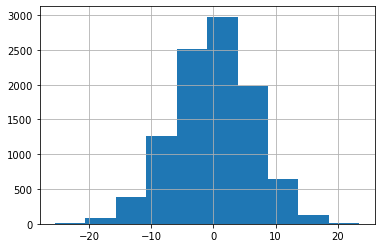

In [14]:
y.hist()

In [15]:
y_not_zero = y > 0
y[y_not_zero] = 1
y[~y_not_zero] = 0
y = y.astype(int)

<AxesSubplot:>

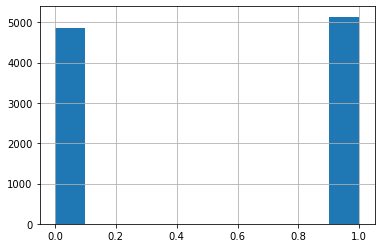

In [16]:
y.hist()

In [17]:
y.value_counts()

1    5139
0    4861
dtype: int64

### Training and testing data

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 60)

#create a decision tree and fit it to training data
clf_dt = DecisionTreeClassifier(random_state = 60)
clf_dt = clf_dt.fit(X_train,y_train)

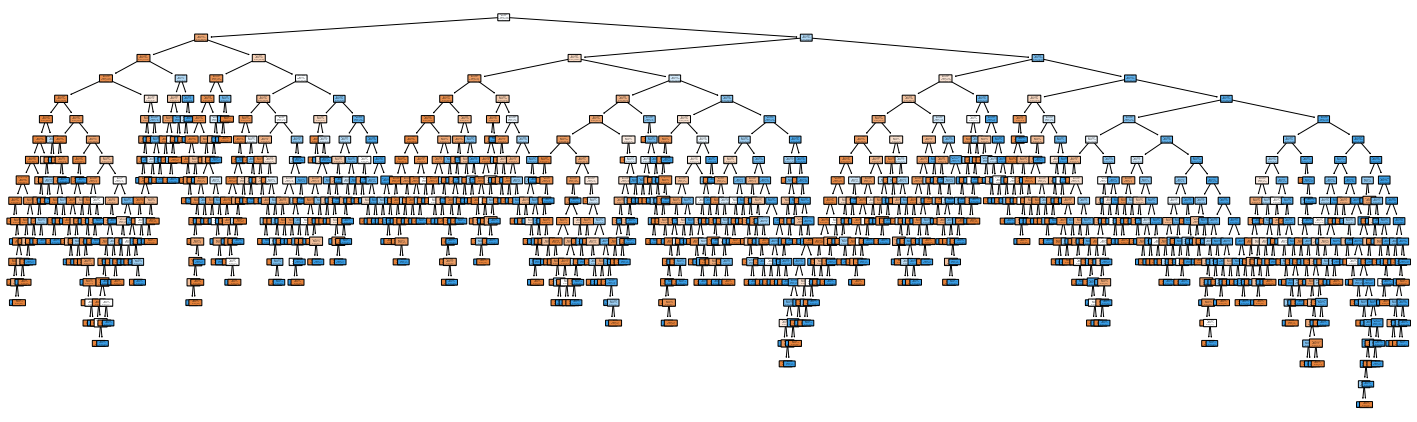

In [19]:
##plot the long tree
plt.figure(figsize = (25,7.5))
plot_tree(clf_dt,
         filled = True,
         rounded = True,
         class_names = ["Traditional bank","Shadow bank"],
         feature_names = X.columns);

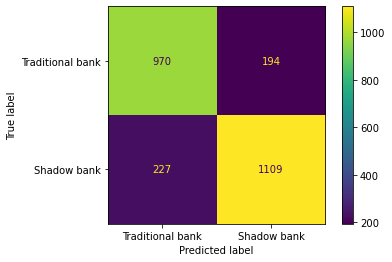

In [20]:
##Plot confusion matrix
plot_confusion_matrix(clf_dt,X_test,y_test,display_labels=["Traditional bank", "Shadow bank"])

Traditional bank borrowers are 83.3% correctly classified and 83.0% correctky classified for Shadow bank borrowers.

In [21]:
y_pred = clf_dt.predict(X_test)
accuracy_long_tree = accuracy_score(y_test, y_pred )
accuracy_long_tree

0.8316

### Cost Complexity Pruning
Decision trees are known for the problem of overfitting, thus we need to prune the tree in order to optimize it. Pruning a tree with cost complexity pruning can simplify the whole process of finding a smaller tree that improves the accuracy with the testing data set.

We need to find the value of pruning parameter 'alpha' which controls the pruning. We find out the value of 'alpha' by plotting the accuracy of the tree as a function of different values. It is done foe both, training and testing datasets.

Here we omit the maximum value of alpha as it will lead to pruning of all leaves, leaving only a root and not a tree.

In [22]:
path = clf_dt.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities
#print(ccp_alphas, ccp_alphas.shape)

In [23]:
ccp_alphas = ccp_alphas[:-1]

clf_dts = []

for ccp_alpha in ccp_alphas:
    clf_dt = DecisionTreeClassifier(random_state= 0,
                                   ccp_alpha = ccp_alpha)
    clf_dt.fit(X_train, y_train)
    clf_dts.append(clf_dt)

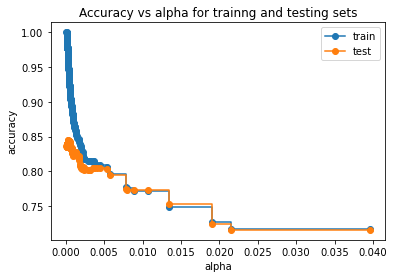

In [24]:
train_scores = [clf_dt.score(X_train,y_train) for clf_dt in clf_dts]
test_scores = [clf_dt.score(X_test,y_test) for clf_dt in clf_dts]

fid, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for trainng and testing sets")
ax.plot(ccp_alphas,train_scores, marker='o', label="train", drawstyle="steps-post")
ax.plot(ccp_alphas,test_scores, marker='o', label="test", drawstyle="steps-post")
ax.legend()
plt.show()

**Cross-Validation** is a resampling method used to improve the model by randomly spliting the sample into training and testing data-sets. It is a popular method because it is simple to understand and generally results in a less biased or less optimistic estimate of the model skill than other methods, such as a simple train/test split.

<AxesSubplot:xlabel='tree'>

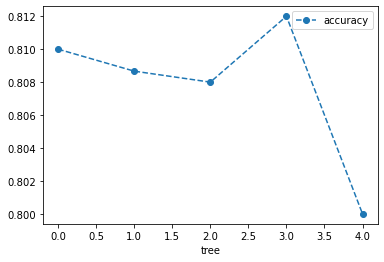

In [25]:
## Cross-validation

clf_dt = DecisionTreeClassifier(random_state = 42, ccp_alpha= 0.002)
scores = cross_val_score(clf_dt, X_train, y_train, cv = 5)

df = pd.DataFrame(data={'tree': range(5), 'accuracy': scores})

df.plot(x = 'tree', y= 'accuracy', marker= 'o', linestyle= '--')

This graph shows that using different training and testing data with same alpha results in different accuracies which means the pruning parameter is sensitive to datasets. So, instead of picking a single training and testing dataset, lets try to use cross-validation to find the optimal alpha

<AxesSubplot:xlabel='alpha'>

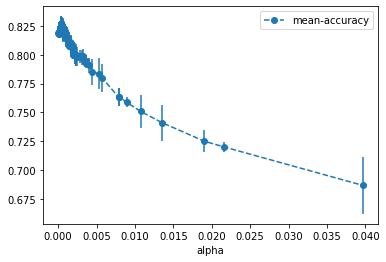

In [26]:
## create an array to store the results of each fold during cross validation
alpha_loop_values = []

## for each candidate value for alpha, we will run 5-fold cross validations. 
## then we will store all the mean and standard deviation of the scores (accuracies) for each call
## to cross-val-score in alpha_loop_values
for ccp_alpha in ccp_alphas:
    clf_dt = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    scores = cross_val_score(clf_dt, X_train, y_train, cv = 4, n_jobs=6)
    alpha_loop_values.append([ccp_alpha, np.mean(scores), np.std(scores)])
    
## now we draw a graph of mean and standard deviations of the scores 
## for each candidate value for alpha
alpha_results = pd.DataFrame(alpha_loop_values,
                            columns = ['alpha','mean-accuracy','std'])

alpha_results.plot(x = 'alpha',
                   y = 'mean-accuracy',
                   yerr = 'std',
                   marker = 'o',
                   linestyle = '--')

In [27]:
# To find the ideal value of alpha 
alpha_results.loc[alpha_results['mean-accuracy'].idxmax()].alpha

0.00042474747474747446

In [28]:
# We will use the value of ccp_alpha from above to prune the long tree
clf_dt_prunned = DecisionTreeClassifier(random_state = 42, 
                                        ccp_alpha = 0.00042474747474747446)
clf_dt_prunned = clf_dt_prunned.fit(X_train,y_train)

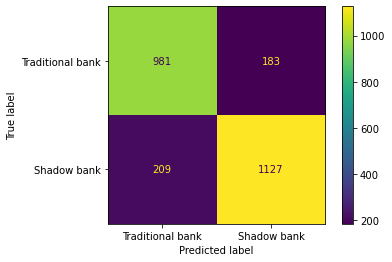

In [29]:
plot_confusion_matrix(clf_dt_prunned,
                     X_test,
                     y_test,
                     display_labels = ["Traditional bank","Shadow bank"])

From the confusion matrix, we can calculate that the traditional bank borrowers are **981+183=1164**, 981 i.e **84.2%** borrowers are correctly classified. For the Shadow bank borrowers which are **209+1127**, 1127 i.e **84.3%** are correctly classified. 

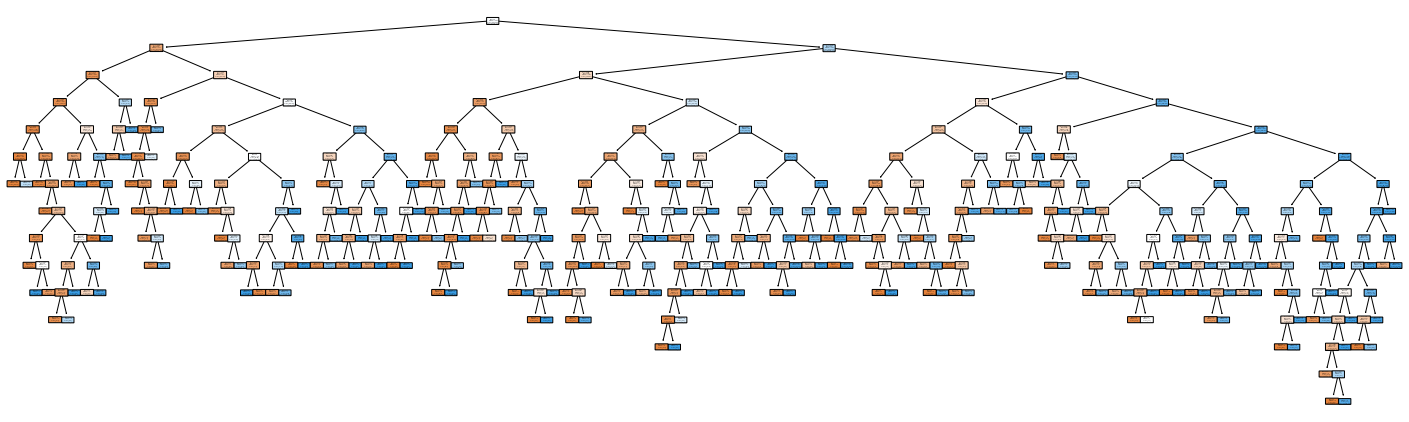

In [30]:
plt.figure(figsize = (25,7.5))
plot_tree(clf_dt_prunned,
          filled = True,
          rounded = True,
          class_names = ["Traditional bank","Shadow_banks"],
          feature_names = X.columns);
plt.savefig("pruned_tree.pdf")

In [32]:
y_pred = clf_dt_prunned.predict(X_test)
y_pred

array([1, 1, 1, ..., 0, 1, 1])

In [33]:
accuracy = accuracy_score(y_test, y_pred )
accuracy

0.8432

#### Interpretation
The majority class is **Shadow bank** from the pruned tree. The accuracy of the model has been increased from **83.16%** to **84.32%** due to cost-complexity pruning. 
This also shows that given the enthnicity and racial differences of people, Shadow banks originate greater loan than traditional banks from the borrowers at the market level or county level. 

## Random Forest

In [31]:
##Split the data into training and testing data-sets
X_rtrain, X_rtest, y_rtrain, y_rtest = train_test_split(X, y, random_state = 60)

In [34]:
## Applying Random-Forest classifier with 120 trees with the tarining and testing data-sets
rf = RandomForestClassifier(n_estimators = 120, random_state = 60, n_jobs= 6, verbose = 1, )
rf.fit(X_rtrain, y_rtrain)

[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.2s
[Parallel(n_jobs=6)]: Done 120 out of 120 | elapsed:    0.5s finished


RandomForestClassifier(n_estimators=120, n_jobs=6, random_state=60, verbose=1)

In [35]:
y_pred = rf.predict(X_rtest)
y_pred

[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done 120 out of 120 | elapsed:    0.0s finished


array([1, 1, 1, ..., 0, 1, 1])

In [36]:
y_pred.tolist().count(0), y_pred.tolist().count(1)

(1218, 1282)

[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done 120 out of 120 | elapsed:    0.0s finished


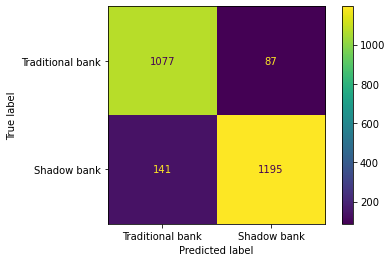

In [37]:
plot_confusion_matrix(rf,
                     X_rtest,
                     y_rtest,
                     display_labels = ["Traditional bank","Shadow bank"])

In [38]:
print(classification_report(y_rtest, y_pred))
print( "Accuracy_Score ",accuracy_score(y_rtest, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.93      0.90      1164
           1       0.93      0.89      0.91      1336

    accuracy                           0.91      2500
   macro avg       0.91      0.91      0.91      2500
weighted avg       0.91      0.91      0.91      2500

Accuracy_Score  0.9088


#### Interpretation:
From the confusion matrix, the random forest has correctly predicted **92.5%** (1077+87) traditional bank borrowers and  **89.4%** of Shadow bank borrowers. 
The accuracy of the model has been increased from 84.3% of pruned tree to **90.88%** with random forest. The popular class is still **Shadow bank** which proves the results under inspection. 

# Simulation Study
In this Simulation, the important variable x6 which is county_code is removed and the sample is doubled from 10000 to 20000.
Let's see if the results changes and how important is the county_code variable

In [62]:
def gen_samples(global_mean, global_std, n_classes, n_samples=20_000, lower_bound=100, name_of_feature='x1'):
    
    classwise_means = np.random.normal(global_mean, global_std, n_classes)
    
    classwise_std = np.abs(
        np.random.randint(0, global_std*2, n_classes) 
        + np.random.randn(n_classes)
    )
    
    proportions = return_proportions(n_classes, n_samples, lower_bound)
    
    print(f'For {name_of_feature}:\n---\nMeans: {np.round(classwise_means, 2)}')
    print(f'StdDev: {np.round(classwise_std, 2)}')
    print(f'Proportion: {proportions}\n---\n---')
    
    samples = np.concatenate(
        [np.random.normal(classwise_means[i], 
                          classwise_std[i],
                          proportions[i])
         for i in range(n_classes)
        ]
    )
    
    class_labels = np.concatenate([np.full(prop, index)
                   for index, prop in enumerate(proportions)
                   ])
    
    df = pd.DataFrame({name_of_feature:samples, f'{name_of_feature}_class':class_labels})
    
    if df[f'{name_of_feature}_class'].value_counts().isin(proportions).all():
        df[name_of_feature] -= df[name_of_feature].mean()
        df[name_of_feature] /= 2 * df[name_of_feature].std()
        return df
    else:
        print('Kuch to galat hai')

In [63]:
## removing x6 - county_code from the data generating process
global_means = [2.23, 1.73, 2.26, 5.17, 5.5, 1.38, 1.56, 1.86]
globals_std = [1.58, 0.61, 0.73, 1.62, 1.45, 0.58, 0.81, 0.98]
global_n_classes = [6, 4, 4, 7, 7, 3, 4, 3]
names_of_features = ['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x8', 'x9']

In [64]:
X = pd.concat([
    gen_samples(global_mean, global_std, n_classes, 
                n_samples=20_000, lower_bound=50, 
                name_of_feature=name,
               )
    for global_mean, global_std, n_classes, name in zip(
        global_means, globals_std, global_n_classes, names_of_features
    )],
    axis=1,
)

For x1:
---
Means: [2.62 4.53 3.64 1.   0.12 1.9 ]
StdDev: [1.03 0.52 1.15 1.86 0.64 0.19]
Proportion: [2458, 815, 5839, 4303, 5161, 1424]
---
---
For x2:
---
Means: [1.44 1.15 1.01 0.56]
StdDev: [1.1  1.27 1.73 0.25]
Proportion: [585, 7748, 2443, 9224]
---
---
For x3:
---
Means: [2.14 2.59 2.69 3.23]
StdDev: [0.93 2.35 0.48 0.34]
Proportion: [1017, 2318, 3869, 12796]
---
---
For x4:
---
Means: [4.32 3.53 4.85 5.67 7.53 5.43 5.01]
StdDev: [0.12 1.18 1.26 0.89 0.01 0.54 4.13]
Proportion: [1711, 4004, 2924, 4830, 183, 3973, 2375]
---
---
For x5:
---
Means: [5.46 4.83 5.09 5.6  4.65 3.38 4.17]
StdDev: [0.04 1.12 0.08 1.43 1.11 1.03 0.78]
Proportion: [348, 1680, 5415, 6223, 1594, 2232, 2508]
---
---
For x7:
---
Means: [1.42 0.9  1.42]
StdDev: [0.22 1.01 0.54]
Proportion: [5672, 10117, 4211]
---
---
For x8:
---
Means: [0.97 1.56 1.53 2.24]
StdDev: [1.62 0.68 1.29 0.94]
Proportion: [5305, 6323, 3537, 4835]
---
---
For x9:
---
Means: [1.5  2.39 1.49]
StdDev: [0.   0.49 0.4 ]
Proportion: [8217

In [65]:
X

,x1,x1_class,x2,x2_class,x3,x3_class,x4,x4_class,x5,x5_class,x7,x7_class,x8,x8_class,x9,x9_class
0,0.170007,0,0.063335,0,-0.484794,0,-0.138875,0,0.213613,0,0.211115,0,-0.317404,0,-0.151845,0
1,-0.123008,0,0.131053,0,-0.282741,0,-0.164555,0,0.231294,0,0.103465,0,0.241214,0,-0.155789,0
2,-0.059543,0,0.761358,0,-0.147905,0,-0.195017,0,0.247391,0,0.197826,0,-0.238731,0,-0.156603,0
3,0.119982,0,0.024656,0,-0.835919,0,-0.154027,0,0.234048,0,0.157610,0,-0.280586,0,-0.152345,0
4,0.218333,0,0.841684,0,0.520411,0,-0.185708,0,0.228145,0,0.013221,0,-0.217922,0,-0.148764,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,-0.002064,5,-0.299380,3,0.166634,3,-0.457743,6,-0.714997,6,-0.357122,2,-0.610786,3,-0.369320,2
19996,0.005622,5,0.071504,3,-0.191295,3,-0.426491,6,0.003094,6,0.061087,2,0.332443,3,-0.697605,2
19997,-0.018345,5,-0.318964,3,0.196993,3,0.527093,6,-0.564952,6,-0.300900,2,-0.202344,3,-0.344477,2
19998,-0.008893,5,-0.241878,3,0.149964,3,-0.222826,6,0.178626,6,0.040116,2,-0.072468,3,-0.495311,2


In [66]:
beta = (6,3,3,4,4,6,2,2)
eps = np.random.normal(loc=0 , scale=1, size= 20000)

<AxesSubplot:>

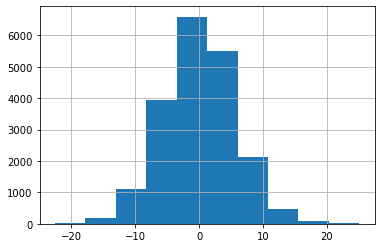

In [67]:
y = X.x1*beta[0]+ X.x2*beta[1] + X.x3*beta[2] + \
    X.x4*beta[3]+ X.x5*beta[4] + \
    X.x6*beta[5]+ X.x8*beta[6] + X.x9*beta[7] + eps

y.hist()

In [68]:
y_not_zero = y > 0
y[y_not_zero] = 1
y[~y_not_zero] = 0
y = y.astype(int)

In [69]:
y.value_counts()

0    10043
1     9957
dtype: int64

In [70]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 60)

#create a decision tree and fit it to training data
clf_dt = DecisionTreeClassifier(random_state = 60)
clf_dt = clf_dt.fit(X_train,y_train)

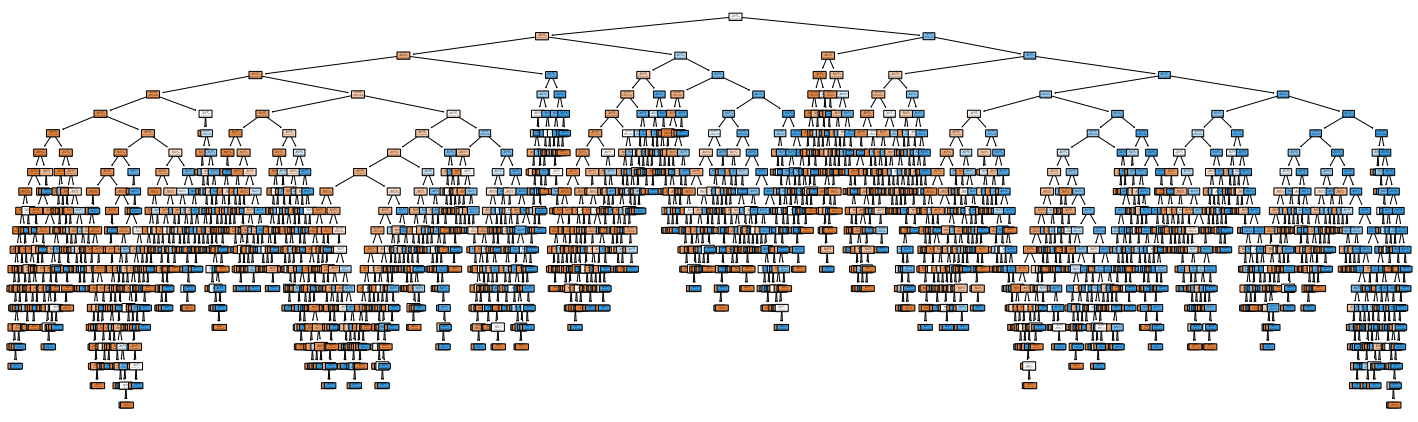

In [71]:
##plot the long tree
plt.figure(figsize = (25,7.5))
plot_tree(clf_dt,
         filled = True,
         rounded = True,
         class_names = ["Traditional bank","Shadow bank"],
         feature_names = X.columns);

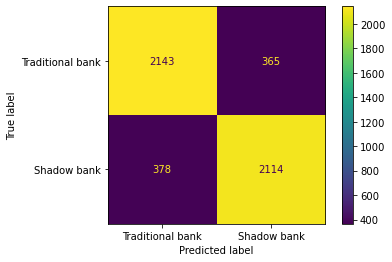

In [73]:
##Plot confusion matrix
plot_confusion_matrix(clf_dt,X_test,y_test,display_labels=["Traditional bank", "Shadow bank"])

In [74]:
y_pred = clf_dt.predict(X_test)
accuracy_long_tree = accuracy_score(y_test, y_pred )
accuracy_long_tree

0.8514

In [75]:
path = clf_dt.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities
#print(ccp_alphas, ccp_alphas.shape)

In [76]:
ccp_alphas = ccp_alphas[:-1]

clf_dts = []

for ccp_alpha in ccp_alphas:
    clf_dt = DecisionTreeClassifier(random_state= 0,
                                   ccp_alpha = ccp_alpha)
    clf_dt.fit(X_train, y_train)
    clf_dts.append(clf_dt)

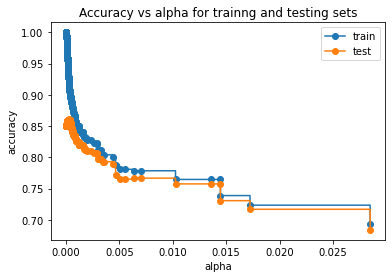

In [77]:
train_scores = [clf_dt.score(X_train,y_train) for clf_dt in clf_dts]
test_scores = [clf_dt.score(X_test,y_test) for clf_dt in clf_dts]

fid, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for trainng and testing sets")
ax.plot(ccp_alphas,train_scores, marker='o', label="train", drawstyle="steps-post")
ax.plot(ccp_alphas,test_scores, marker='o', label="test", drawstyle="steps-post")
ax.legend()
plt.show()

<AxesSubplot:xlabel='tree'>

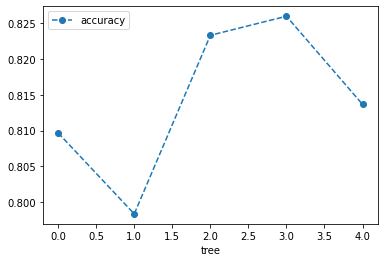

In [78]:
## Cross-validation

clf_dt = DecisionTreeClassifier(random_state = 42, ccp_alpha= 0.002)
scores = cross_val_score(clf_dt, X_train, y_train, cv = 5)

df = pd.DataFrame(data={'tree': range(5), 'accuracy': scores})

df.plot(x = 'tree', y= 'accuracy', marker= 'o', linestyle= '--')

<AxesSubplot:xlabel='alpha'>

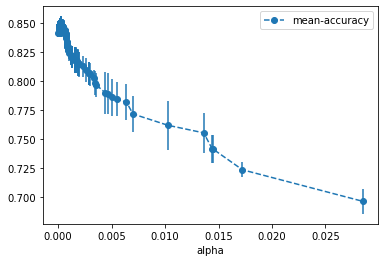

In [79]:
## create an array to store the results of each fold during cross validation
alpha_loop_values = []

## for each candidate value for alpha, we will run 5-fold cross validations. 
## then we will store all the mean and standard deviation of the scores (accuracies) for each call
## to cross-val-score in alpha_loop_values
for ccp_alpha in ccp_alphas:
    clf_dt = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    scores = cross_val_score(clf_dt, X_train, y_train, cv = 4, n_jobs=6)
    alpha_loop_values.append([ccp_alpha, np.mean(scores), np.std(scores)])
    
## now we draw a graph of mean and standard deviations of the scores 
## for each candidate value for alpha
alpha_results = pd.DataFrame(alpha_loop_values,
                            columns = ['alpha','mean-accuracy','std'])

alpha_results.plot(x = 'alpha',
                   y = 'mean-accuracy',
                   yerr = 'std',
                   marker = 'o',
                   linestyle = '--')

In [80]:
alpha_results.loc[alpha_results['mean-accuracy'].idxmax()].alpha

0.00023642135642135652

In [81]:
clf_dt_prunned = DecisionTreeClassifier(random_state = 42, 
                                        ccp_alpha = 0.00023642135642135652)
clf_dt_prunned = clf_dt_prunned.fit(X_train,y_train)

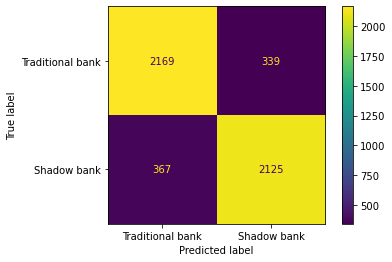

In [82]:
plot_confusion_matrix(clf_dt_prunned,
                     X_test,
                     y_test,
                     display_labels = ["Traditional bank","Shadow bank"])

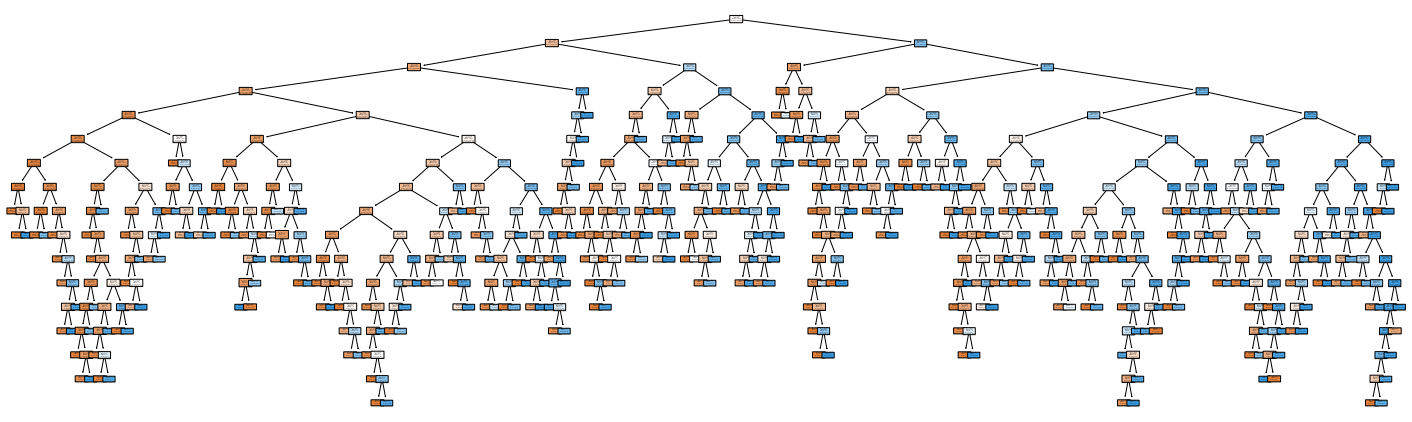

In [83]:
plt.figure(figsize = (25,7.5))
plot_tree(clf_dt_prunned,
          filled = True,
          rounded = True,
          class_names = ["Traditional bank","Shadow_banks"],
          feature_names = X.columns);
plt.savefig("pruned_tree1.pdf")

In [84]:
y_pred = clf_dt_prunned.predict(X_test)
y_pred

array([1, 1, 0, ..., 0, 1, 0])

In [85]:
accuracy = accuracy_score(y_test, y_pred )
accuracy

0.8588

## Random Forest

In [86]:
X_rtrain, X_rtest, y_rtrain, y_rtest = train_test_split(X, y, random_state = 60)

In [87]:
rf = RandomForestClassifier(n_estimators = 120, random_state = 60, n_jobs= 6, verbose = 1, )
rf.fit(X_rtrain, y_rtrain)

[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=6)]: Done 120 out of 120 | elapsed:    0.8s finished


RandomForestClassifier(n_estimators=120, n_jobs=6, random_state=60, verbose=1)

In [88]:
y_pred = rf.predict(X_rtest)
y_pred

[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done 120 out of 120 | elapsed:    0.0s finished


array([1, 0, 0, ..., 1, 0, 0])

In [89]:
y_pred.tolist().count(0), y_pred.tolist().count(1)

(2518, 2482)

[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done 120 out of 120 | elapsed:    0.0s finished


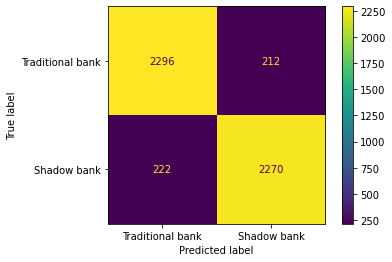

In [90]:
plot_confusion_matrix(rf,
                     X_rtest,
                     y_rtest,
                     display_labels = ["Traditional bank","Shadow bank"])

In [91]:
print(classification_report(y_rtest, y_pred))
print( "Accuracy_Score ",accuracy_score(y_rtest, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.92      0.91      2508
           1       0.91      0.91      0.91      2492

    accuracy                           0.91      5000
   macro avg       0.91      0.91      0.91      5000
weighted avg       0.91      0.91      0.91      5000

Accuracy_Score  0.9132
